In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
import networkx as nx
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import MultiLabelBinarizer

In [2]:
# NUMBER_NODES = 9
NUMBER_NODES = 7
# NUMBER_NODES = 5
DATASET_PATH = f'../../../datasets/examples/opt_band_{NUMBER_NODES}_nodes_graph.csv'

def load_data():
    featuresNumber = (NUMBER_NODES * NUMBER_NODES - NUMBER_NODES) // 2 

    def get_tuple_dataset(row):
        X = row[0 : featuresNumber].astype('float32')
        Y = row[featuresNumber: ].astype('float32') # opt_band is in target
        return X, Y

    df = pd.read_csv(DATASET_PATH)
    train_dataset_df = df.sample(frac=0.8)
    df_remaining = df.drop(index=train_dataset_df.index)
    val_dataset_df = df_remaining.sample(frac=0.7)
    test_dataset_df = df_remaining.drop(index=val_dataset_df.index)

    train_dataset = list(map(get_tuple_dataset, train_dataset_df.to_numpy()))
    val_dataset = list(map(get_tuple_dataset, val_dataset_df.to_numpy()))
    test_dataset = list(map(get_tuple_dataset, test_dataset_df.to_numpy()))
    return train_dataset, val_dataset, test_dataset

In [3]:
train_dataset, val_dataset, test_dataset = load_data()

In [4]:
def getGraph(upperTriangleAdjMatrix):
    dense_adj = np.zeros((NUMBER_NODES, NUMBER_NODES))
    dense_adj = np.zeros((NUMBER_NODES, NUMBER_NODES))
    k = 0
    for i in range(NUMBER_NODES):
        for j in range(NUMBER_NODES):
            if i == j:
                continue
            elif i < j:
                dense_adj[i][j] = upperTriangleAdjMatrix[k]
                k += 1
            else:
                dense_adj[i][j] = dense_adj[j][i]
    return dense_adj

In [5]:
def processDataToImage(graphInput):
    graph_adj = getGraph(graphInput)
    plt.imshow(graph_adj, cmap="gray")
    plt.xticks([])
    plt.yticks([])
    plt.savefig(f'./Graph_adj_input_mse2.png')
    plt.clf()
    image_input = tf.keras.preprocessing.image.load_img(f'./Graph_adj_input_mse2.png')
    image_input_arr = tf.keras.preprocessing.image.img_to_array(image_input)
    image_input_np = np.array(image_input_arr)
    image_input_np = image_input_np / 255.0

    image_input_np = tf.image.resize(image_input_np, [256, 256])
    return image_input_np


In [6]:
def getData(dataset):
    train_images = []
    train_nodelist = []
    train_bandwidth = []
    for graphInput, target in dataset:
        optband = target[0]
        graphNodeList = target[1 : ]
        x_image = processDataToImage(graphInput)
        train_images.append(x_image)
        train_nodelist.append(graphNodeList)
        train_bandwidth.append([optband])
    return np.array(train_images), (np.array(train_nodelist) / 10), np.array(train_bandwidth)

In [7]:
def getData_2(dataset):
    train_images = []
    train_nodelist = []
    for graphInput, target in dataset:
        graphNodeList = target[1 : ]
        x_image = processDataToImage(graphInput)
        train_images.append(x_image)
        train_nodelist.append(graphNodeList)
    # mlb = MultiLabelBinarizer()
    # labels = mlb.fit_transform(train_nodelist)
    return np.array(train_images), np.array(train_nodelist) / 10

In [8]:
# train_images, train_nodelist, train_bandwidth = getData(train_dataset)
# val_images, val_nodelist, val_bandwidth = getData(val_dataset)
# test_images, test_nodelist, test_bandwidth = getData(test_dataset)
# print(train_images.shape)
# print(train_nodelist.shape)
# print(train_bandwidth.shape)

In [9]:
train_images, train_nodelist = getData_2(train_dataset)
val_images, val_nodelist= getData_2(val_dataset)
test_images, test_nodelist = getData_2(test_dataset)

# aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
# 	height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
# 	horizontal_flip=True, fill_mode="nearest")

print(train_images.shape)
print(train_nodelist.shape)

(835, 256, 256, 3)
(835, 7)


<Figure size 432x288 with 0 Axes>

In [10]:
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(256, 256, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

model = tf.keras.models.Sequential([
  # data_augmentation,
  # layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(NUMBER_NODES)
])

model.compile(optimizer='adam',
              loss='mse',
              metrics=['accuracy'])

history = model.fit(
    train_images, train_nodelist,
    validation_data=(val_images, val_nodelist),
    epochs=128,
)

Epoch 1/128
27/27 [==============================] - 117s 4s/step - loss: 3.3071 - accuracy: 0.0275 - val_loss: 0.1066 - val_accuracy: 0.0068
Epoch 2/128
27/27 [==============================] - 117s 4s/step - loss: 0.0863 - accuracy: 0.0036 - val_loss: 0.0661 - val_accuracy: 0.0068
Epoch 3/128
27/27 [==============================] - 109s 4s/step - loss: 0.0486 - accuracy: 0.0623 - val_loss: 0.0382 - val_accuracy: 0.2534
Epoch 4/128
27/27 [==============================] - 114s 4s/step - loss: 0.0357 - accuracy: 0.3078 - val_loss: 0.0349 - val_accuracy: 0.3356
Epoch 5/128
27/27 [==============================] - 107s 4s/step - loss: 0.0345 - accuracy: 0.3485 - val_loss: 0.0356 - val_accuracy: 0.3562
Epoch 6/128
27/27 [==============================] - 108s 4s/step - loss: 0.0342 - accuracy: 0.3677 - val_loss: 0.0345 - val_accuracy: 0.3562
Epoch 7/128
27/27 [==============================] - 77s 3s/step - loss: 0.0335 - accuracy: 0.3593 - val_loss: 0.0345 - val_accuracy: 0.3288
Epoch 8

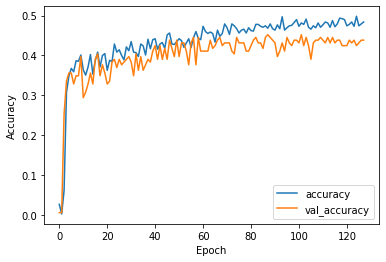

In [11]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

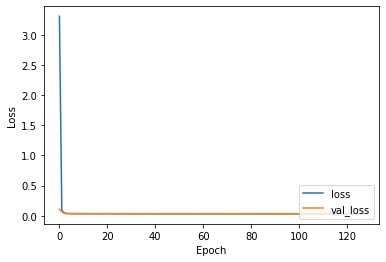

In [12]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

In [13]:
# test = np.array([test_images[0]])
pred = model.predict(test_images)
true = test_nodelist
# print(pred)
print("Pred")
print((pred * 10).round())
print("True")
print(true * 10)

Pred
[[2. 5. 3. 1. 3. 3. 3.]
 [2. 5. 4. 1. 3. 4. 3.]
 [3. 5. 3. 2. 3. 2. 3.]
 [2. 4. 5. 2. 4. 2. 3.]
 [2. 2. 3. 6. 4. 2. 3.]
 [2. 3. 3. 4. 3. 2. 3.]
 [2. 3. 4. 3. 4. 2. 3.]
 [2. 3. 4. 5. 4. 2. 3.]
 [2. 3. 3. 4. 3. 2. 3.]
 [2. 3. 3. 5. 3. 2. 3.]
 [2. 2. 4. 4. 4. 2. 2.]
 [2. 3. 3. 4. 3. 2. 3.]
 [2. 3. 4. 4. 3. 2. 3.]
 [2. 2. 4. 5. 4. 2. 2.]
 [2. 2. 4. 4. 4. 2. 2.]
 [2. 2. 3. 4. 4. 2. 2.]
 [2. 2. 4. 4. 4. 2. 2.]
 [2. 1. 5. 5. 4. 2. 2.]
 [2. 3. 3. 4. 3. 3. 3.]
 [2. 3. 3. 5. 3. 2. 3.]
 [2. 3. 3. 5. 3. 2. 3.]
 [2. 3. 4. 4. 4. 2. 2.]
 [2. 4. 4. 3. 3. 2. 3.]
 [2. 2. 5. 4. 4. 2. 2.]
 [2. 1. 4. 6. 4. 2. 2.]
 [2. 2. 5. 2. 4. 2. 2.]
 [2. 1. 5. 4. 4. 2. 2.]
 [2. 2. 4. 4. 4. 2. 2.]
 [2. 3. 4. 1. 3. 3. 3.]
 [2. 4. 5. 2. 3. 3. 3.]
 [2. 3. 4. 4. 4. 2. 2.]
 [2. 3. 3. 4. 3. 2. 3.]
 [3. 3. 3. 5. 3. 2. 3.]
 [2. 2. 4. 5. 4. 2. 2.]
 [2. 3. 4. 4. 3. 3. 3.]
 [2. 3. 4. 4. 4. 2. 3.]
 [2. 2. 4. 5. 4. 2. 2.]
 [2. 2. 4. 4. 4. 2. 2.]
 [2. 4. 4. 2. 3. 2. 3.]
 [2. 3. 4. 4. 4. 2. 3.]
 [2. 3. 4. 2. 3. 3. 3.]
 [2. 1. 2. 